<div class="alert alert-block alert-success">
    <b><center>Pytorch LIBRARY</center></b>
    <b><center>CIFAR 10 Advanced</center></b>
</div>

# Configure Learning Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests
from PIL import Image

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Prepare Data

In [4]:
augumentation = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])
])

In [5]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([.5, .5, .5], [.5, .5, .5])
])
res_train = datasets.CIFAR10("./datas", train=True, transform=augumentation, download=True)
res_valid = datasets.CIFAR10("./datas", train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
len(res_train), len(res_valid)

(50000, 10000)

In [7]:
load_train = torch.utils.data.DataLoader(res_train, batch_size=2000, shuffle=True)
load_valid = torch.utils.data.DataLoader(res_valid, batch_size=2000, shuffle=True)

In [8]:
iter_train = iter(load_train)
images, labels = iter_train.next()
images.shape, labels.shape

(torch.Size([2000, 3, 32, 32]), torch.Size([2000]))

In [9]:
def im_convert(tensor):
    image = tensor.clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 255)
    return image

In [10]:
class_cifar = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

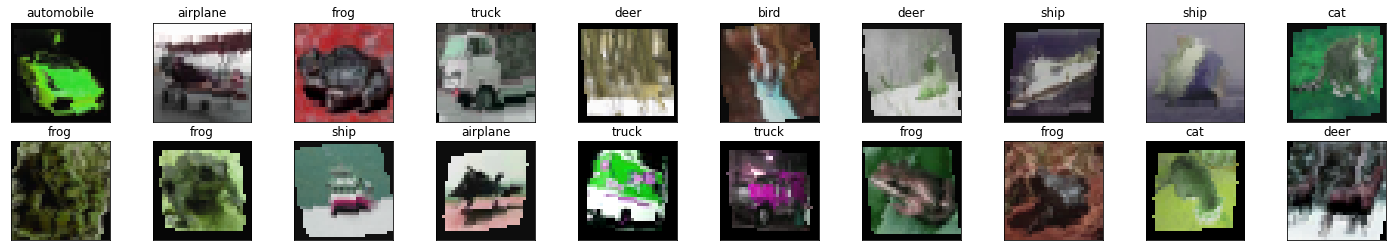

In [11]:
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(class_cifar[labels[idx].item()])

# Generate Model

In [12]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.drop1 = nn.Dropout(0.5)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(4*4*64, 500)
        self.act3 = nn.ReLU()
        self.drop2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    
    def forward(self, x):
        x = self.pool1(self.act1(self.conv1(x)))
        x = self.pool2(self.act2(self.drop1(self.conv2(x))))
        x = self.pool3(self.act3(self.conv3(x)))
        
        x = x.view(-1, 4*4*64)
        x = self.drop2(self.act3(self.fc1(x)))
        x = self.fc2(x)
        return x

In [13]:
model = Classifier().to(device)
model

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop1): Dropout(p=0.5, inplace=False)
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [14]:
fn_loss = nn.CrossEntropyLoss()
fn_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [15]:
epochs = 30
size_bunch_train = len(load_train)
size_bunch_valid = len(load_valid)

In [ ]:
history = []
for epoch in range(epochs):
    loss_learns, accu_learns, loss_valids, accu_valids = .0, .0, .0, .0

    # Learning Step
    for datas, labels in load_train:
        # set device
        datas = datas.to(device)
        labels = labels.to(device)
        
        # predict & calculate a loss
        preds = model(datas)
        loss = fn_loss(preds, labels)
        
        # backpropagation
        fn_optimizer.zero_grad()
        loss.backward()
        fn_optimizer.step()
        
        # Caculating loss/accuracy for monitoring
        loss_learns += loss.item()
        _, pred_label = torch.max(preds, 1)
        accu_learns += torch.sum(pred_label == labels.data).item() / len(pred_label) * 100
    
    # Validating Step
    for datas, labels in load_valid:
        # set device
        datas = datas.to(device)
        labels = labels.to(device)
        
        # predict & calculate a loss
        preds = model(datas)
        loss = fn_loss(preds, labels)
        
        # Caculating loss/accuracy for monitoring
        loss_valids += loss.item()
        _, pred_label = torch.max(preds, 1)
        accu_valids += torch.sum(pred_label == labels.data).item() / len(pred_label) * 100
    
    loss_learn = loss_learns / size_bunch_train
    accu_learn = accu_learns / size_bunch_train
    loss_valid = loss_valids / size_bunch_valid
    accu_valid = accu_valids / size_bunch_valid
    history.append({"loss": loss_learn, "accuracy": accu_learn, "validation loss": loss_valid, "validation accuracy": accu_valid})
    
    print(f"{epoch+1:02d} step -> loss: {loss_learn:.4f}, accuracy: {accu_learn:.2f} %, validation loss: {loss_valid:.4f}, validation accuracy: {accu_valid:.2f} %")

01 step -> loss: 2.0917, accuracy: 23.65 %, validation loss: 1.8582, validation accuracy: 33.03 %
02 step -> loss: 1.8250, accuracy: 34.37 %, validation loss: 1.6552, validation accuracy: 40.60 %
03 step -> loss: 1.6957, accuracy: 38.68 %, validation loss: 1.5638, validation accuracy: 43.28 %
04 step -> loss: 1.6151, accuracy: 41.38 %, validation loss: 1.4906, validation accuracy: 46.20 %
05 step -> loss: 1.5685, accuracy: 43.08 %, validation loss: 1.4458, validation accuracy: 47.61 %
06 step -> loss: 1.5289, accuracy: 44.88 %, validation loss: 1.4049, validation accuracy: 49.28 %
07 step -> loss: 1.4945, accuracy: 46.20 %, validation loss: 1.3769, validation accuracy: 50.12 %
08 step -> loss: 1.4647, accuracy: 47.68 %, validation loss: 1.3457, validation accuracy: 51.43 %
09 step -> loss: 1.4352, accuracy: 48.57 %, validation loss: 1.3171, validation accuracy: 52.32 %
10 step -> loss: 1.4232, accuracy: 49.11 %, validation loss: 1.2947, validation accuracy: 53.59 %
11 step -> loss: 1.3

In [ ]:
df_history = pd.DataFrame.from_records(history)

<AxesSubplot:>

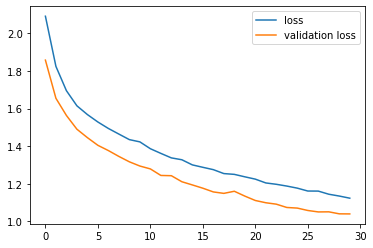

In [ ]:
df_history[["loss", "validation loss"]].plot()

<AxesSubplot:>

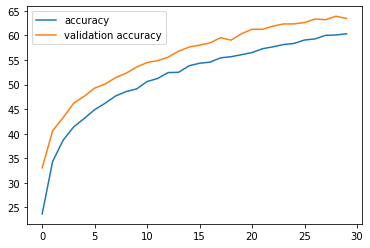

In [ ]:
df_history[["accuracy", "validation accuracy"]].plot()

# Prediction

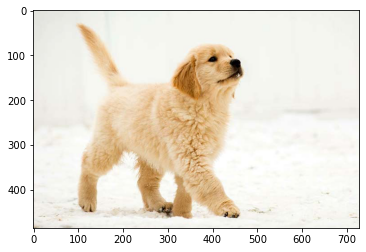

In [ ]:
url = "https://www.akc.org/wp-content/uploads/2017/11/Golden-Retriever-Puppy.jpg"
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

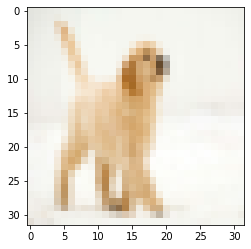

In [ ]:
img_pred = transform(img)
plt.imshow(im_convert(img_pred))

In [ ]:
img_input = img_pred.to(device).unsqueeze(0)
pred = model(img_input)
_, pred_label = torch.max(pred, 1)
class_cifar[pred_label.item()]

'dog'